In [1]:
# necessary libraries for pre-processing
import utils
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

## Statistical Analysis

In [2]:
def get_col_max(df, col):
    '''Get the maximum value of a given column'''
    return df[col].max()

def get_col_min(df, col):
    '''Get the minimum value of a given column'''
    return df[col].min()

def get_col_count(df, col):
    '''Get the number of elements of a given column'''
    return df[col].count()

def get_col_avg(df, col):
    '''Get the average value of a given column'''
    return df[col].mean()

def get_col_std(df, col):
    '''Get the standar deviation value of a given column'''
    return df[col].std()

# Useful functions for preprocessing

In [3]:
def convert_date(df, column, date_format='%y%m%d'):
    '''Convert the given column containg dates in the given format
    to the standard date format and type'''
    copy_df = df.copy()
    copy_df[column] = pd.to_datetime(copy_df[column], format=date_format)

    return copy_df

In [4]:
def encode_column(df, column, options_list):
    '''Encode the given column of the given dataframe.
    All column values should be present in the options_list.'''
    copy_df = df.copy()

    le = preprocessing.LabelEncoder()
    le.fit(options_list)
    copy_df[column] = le.transform(copy_df[column])
    
    return copy_df

In [5]:
def normalize_columns(df, columns):
    '''Normalize the given columns for range between [0, 1]'''
    for col in columns:
        col_min = get_col_min(df, col)
        col_max = get_col_max(df, col)
        
        df[col] = (df[col] - col_min)/\
                    (col_max - col_min)

In [6]:
def get_df_correlation(df):
    '''Get the correlation between the dataframe features'''
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                     square=True, linewidths=.1, cbar_kws={"shrink": .5})
    
    y_lim = ax.get_ylim();
    ax.set_ylim(np.ceil(y_lim[0]), np.floor(y_lim[1]))

    plt.show()

In [7]:
def scatterplot_two_cols(df, col1, col2):
    '''Get a scatterplot for the given two columns'''
    # Set up the matplotlib figure
    plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.scatterplot(data=df, x=col1, y=col2,
                    hue='status',palette=cmap, sizes=(47,47))
    plt.show()

## Imputation

In [8]:
def get_null_summary(dataset):
    '''Get a null summary display'''
    display(dataset.isnull().mean())

In [9]:
def clean_nulls(dataset, threshold=0.7):
    '''Clean nulls from the given table.
    If the nulls in a column are higher than the given threshold the entire column is deleted.
    If the nulls in a row are higher than the row, the row is also deleted.
    The threshold is a value between 0 and 1'''
    #Dropping columns with missing value rate higher than threshold
    dataset = dataset[dataset.columns[dataset.isnull().mean() < threshold]]

    #Dropping rows with missing value rate higher than threshold
    dataset = dataset.loc[dataset.isnull().mean(axis=1) < threshold]
    
    return dataset

In [10]:
def numerical_imputation(dataset, replacer=None):
    '''When null values exist, set them using the median of the colum,
    or a replacer, if one was given'''
    dataset = dataset.fillna(replacer if replacer else dataset.median())

    return dataset

In [11]:
def categorical_imputation(dataset, column_name, replacer=None):
    '''Replace the inexistent values of the given column with the given replacer.
    If None replacer was ginve, use the column maximum value'''
    #Max fill function for categorical columns
    dataset[column_name].fillna(replacer if replacer else \
                                dataset[column_name].value_counts()
                                                    .idxmax(),
                                inplace=True)
    
    return dataset

## Handling Outliers

In [12]:
def display_to_drop_std(dataset, column, mult_factor=3):
    '''Display the rows that will be dropped using the std approach'''
    upper_lim = dataset[column].mean() + dataset[column].std() * mult_factor
    lower_lim = dataset[column].mean() - dataset[column].std() * mult_factor

    display(dataset[(dataset[column] >= upper_lim) & (dataset[column] <= lower_lim)])

def drop_outliers_std(dataset, column, mult_factor=3):
    '''Drop the outlier rows with standard deviation'''
    upper_lim = dataset[column].mean() + dataset[column].std() * mult_factor
    lower_lim = dataset[column].mean() - dataset[column].std() * mult_factor

    return dataset[(dataset[column] < upper_lim) & (dataset[column] > lower_lim)]

In [13]:
def display_to_drop_percentile(dataset, column):
    '''Display the rows that will be dropped with Percentiles approach'''
    upper_lim = dataset[column].quantile(.95)
    lower_lim = dataset[column].quantile(.05)

    display(dataset[(dataset[column] >= upper_lim) & (dataset[column] <= lower_lim)])

def drop_outliers_percentile(dataset, column):
    '''Drop the outlier rows with Percentiles approach'''
    upper_lim = dataset[column].quantile(.95)
    lower_lim = dataset[column].quantile(.05)

    data = dataset[(dataset[column] < upper_lim) & (dataset[column] > lower_lim)]

## Binning

In [14]:
def numerical_binning(dataset):
    # TODO
    # https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114
    return False

In [15]:
def categorical_binning(dataset):
    # TODO
    return False

# Feature Engineering

### For a first simpler approach, we will only use the 'loan' table

In [16]:
# Reading the different train tables
loan_df = utils.read_csv_to_df('competition_dataset/loan_train.csv', delimiter=';')
account_df = utils.read_csv_to_df('competition_dataset/account.csv', delimiter=';')
disp_df = utils.read_csv_to_df('competition_dataset/disp.csv', delimiter=';')
card_df = utils.read_csv_to_df('competition_dataset/card_train.csv', delimiter=';')


loan_test_df = utils.read_csv_to_df('competition_dataset/loan_test.csv', delimiter=';')
card_test_df = utils.read_csv_to_df('competition_dataset/card_test.csv', delimiter=';')

print(' ::: Tables Scheme :::')
print('\n\n\t LOAN TABLE')
display(loan_df.head())
print('\n\n\t ACCOUNT TABLE')
display(account_df.head())
print('\n\n\t DISPOSITION TABLE')
display(disp_df.head())
print('\n\n\t CREDIT CARD TABLE')
display(card_df.head())

 ::: Tables Scheme :::


	 LOAN TABLE


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1




	 ACCOUNT TABLE


,account_id,district_id,frequency,date
0,576,55,monthly issuance,930101
1,3818,74,monthly issuance,930101
2,704,55,monthly issuance,930101
3,2378,16,monthly issuance,930101
4,2632,24,monthly issuance,930102




	 DISPOSITION TABLE


,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,3,3,2,DISPONENT
3,4,4,3,OWNER
4,5,5,3,DISPONENT




	 CREDIT CARD TABLE


,card_id,disp_id,type,issued
0,1005,9285,classic,931107
1,104,588,classic,940119
2,747,4915,classic,940205
3,70,439,classic,940208
4,577,3687,classic,940215


 > Raw transactions table representation


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN,NaN,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN,IJ,80269753.0
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN,NaN,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN,NaN,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
396680,515914,1763,961231,withdrawal,withdrawal in cash,14.6,67769.5,payment for statement,NaN,NaN
396681,516262,1765,961231,withdrawal,withdrawal in cash,14.6,19708.1,payment for statement,NaN,NaN
396682,520019,1775,961231,withdrawal,withdrawal in cash,14.6,15944.5,payment for statement,NaN,NaN
396683,517894,1769,961231,withdrawal,withdrawal in cash,14.6,34679.4,payment for statement,NaN,NaN


 > Raw transactions table correlations


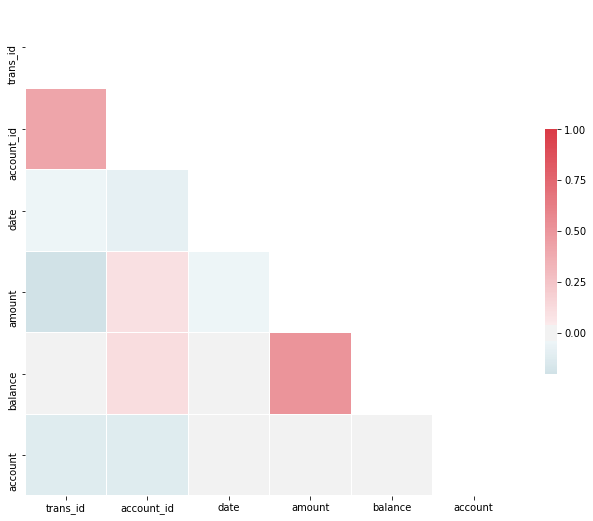

 > Null evaluation in transactions rows


trans_id      0.000000
account_id    0.000000
date          0.000000
type          0.000000
operation     0.178381
amount        0.000000
balance       0.000000
k_symbol      0.466980
bank          0.754863
account       0.742292
dtype: float64

array(['credit in cash', 'collection from another bank', nan,
       'withdrawal in cash', 'remittance to another bank',
       'credit card withdrawal'], dtype=object)

array(['credit', 'withdrawal'], dtype=object)

array([nan, 'interest credited', ' ', 'household',
       'payment for statement', 'insurrance payment',
       'sanction interest if negative balance', 'old-age pension'],
      dtype=object)

,account_id,balance_mean,balance_max,balance_min
0,1,17558.700000,30414.8,1000.0
1,2,32590.624074,67529.6,1100.0
2,4,23648.623077,30623.5,800.0
3,6,30313.279839,40391.5,900.0
4,7,23088.850000,34875.0,900.0
...,...,...,...,...
3365,11333,36827.658173,137043.2,-1291.0
3366,11349,59352.833333,104039.9,200.0
3367,11359,36480.185034,81705.8,1000.0
3368,11362,30869.781308,56055.6,1000.0


,account_id,type,credit_mean,credit_count,credit_max,credit_min
0,1,credit,1992.602000,50,12600.0,19.2
2,2,credit,10394.786364,22,30354.0,13.5
4,4,credit,3348.264706,17,5553.0,66.6
6,6,credit,3603.666667,51,6669.0,70.3
8,7,credit,11635.133333,3,33975.0,30.4
...,...,...,...,...,...,...
6454,11333,credit,8962.814851,101,48037.0,1.1
6456,11349,credit,21108.227273,11,62982.0,39.0
6458,11359,credit,14509.608889,45,40521.0,67.3
6460,11362,credit,8811.758621,29,24212.0,50.1


,account_id,type,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min
1,1,withdrawal,1380.479365,63,7500.0,14.6
3,2,withdrawal,6276.393750,32,22400.0,14.6
5,4,withdrawal,1453.527273,22,4100.0,14.6
7,6,withdrawal,2058.600000,73,11600.0,14.6
9,7,withdrawal,6600.000000,1,6600.0,6600.0
...,...,...,...,...,...,...
6455,11333,withdrawal,8275.402804,107,45300.0,0.1
6457,11349,withdrawal,29640.857143,7,64800.0,8500.0
6459,11359,withdrawal,6149.507843,102,30100.0,14.6
6461,11362,withdrawal,2965.915385,78,16100.0,14.6


 > Table after processment of balance, credits and withdrawals


,account_id,balance_mean,balance_max,balance_min,credit_mean,credit_count,credit_max,credit_min,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min
0,1,17558.700000,30414.8,1000.0,1992.602000,50,12600.0,19.2,1380.479365,63.0,7500.0,14.6
1,2,32590.624074,67529.6,1100.0,10394.786364,22,30354.0,13.5,6276.393750,32.0,22400.0,14.6
2,4,23648.623077,30623.5,800.0,3348.264706,17,5553.0,66.6,1453.527273,22.0,4100.0,14.6
3,6,30313.279839,40391.5,900.0,3603.666667,51,6669.0,70.3,2058.600000,73.0,11600.0,14.6
4,7,23088.850000,34875.0,900.0,11635.133333,3,33975.0,30.4,6600.000000,1.0,6600.0,6600.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3365,11333,36827.658173,137043.2,-1291.0,8962.814851,101,48037.0,1.1,8275.402804,107.0,45300.0,0.1
3366,11349,59352.833333,104039.9,200.0,21108.227273,11,62982.0,39.0,29640.857143,7.0,64800.0,8500.0
3367,11359,36480.185034,81705.8,1000.0,14509.608889,45,40521.0,67.3,6149.507843,102.0,30100.0,14.6
3368,11362,30869.781308,56055.6,1000.0,8811.758621,29,24212.0,50.1,2965.915385,78.0,16100.0,14.6


account_id          0.0
balance_mean        0.0
balance_max         0.0
balance_min         0.0
credit_mean         0.0
credit_count        0.0
credit_max          0.0
credit_min          0.0
withdrawal_mean     0.0
withdrawal_count    0.0
withdrawal_max      0.0
withdrawal_min      0.0
dtype: float64

In [ ]:
def process_transactions(transactions_df, debug=False):
    '''Pre process the transactions table'''
    if debug:
        print(' > Raw transactions table representation')
        display(transactions_df)
        print(' > Raw transactions table correlations')
        get_df_correlation(transactions_df)
        
    if debug:
        print(' > Null evaluation in transactions rows')
        get_null_summary(transactions_df)
        
    # Removing the null columns & processing data
    processed_df = clean_nulls(transactions_df)
    processed_df = convert_date(processed_df, 'date')
    
    # Renaming 'withdrawal in cash' to 'withdrawal'
    processed_df.loc[processed_df["type"]=="withdrawal in cash","type"] = "withdrawal"
    
    display(processed_df['operation'].unique())
    display(processed_df['type'].unique())
    display(processed_df['k_symbol'].unique())

    # Aggregatting transaction balances
    agg_ballance = processed_df.groupby(
        ['account_id']
    ).agg({
        'balance': ['mean', 'max', 'min']
    }).reset_index()
    agg_ballance.columns = ['account_id', 'balance_mean', 'balance_max', 'balance_min']
    display(agg_ballance)

    # Agrregatting credits
    agg_credits = processed_df.groupby(
        ['account_id', 'type']
    ).agg({
        'amount': ['mean', 'count', 'max', 'min'],
    }).reset_index()
    agg_credits.columns = ['account_id', 'type', 'credit_mean', 'credit_count', 'credit_max', 'credit_min']
    agg_credits = agg_credits[agg_credits['type'] == 'credit']
    display(agg_credits)
    
    # Aggregatting withdrawals
    agg_withdrawals = processed_df.groupby(
        ['account_id', 'type']
    ).agg({
        'amount': ['mean', 'count', 'max', 'min'],
    }).reset_index()
    agg_withdrawals.columns = ['account_id', 'type', 'withdrawal_mean', 'withdrawal_count',
                           'withdrawal_max', 'withdrawal_min']
    agg_withdrawals = agg_withdrawals[agg_withdrawals['type'] == 'withdrawal']
    display(agg_withdrawals)

    # Aggregatting all the 3 tables into one
    agg_res = agg_ballance.merge(agg_credits, on='account_id')\
                          .merge(agg_withdrawals, on='account_id', how='left')
    
    # Cleaning nulls and useless columns
    agg_res = agg_res.drop(['type_x', 'type_y'], axis=1)
    agg_res = numerical_imputation(agg_res, 0)
    

    if debug:
        print(' > Table after processment of balance, credits and withdrawals')
        display(agg_res)
        get_null_summary(agg_res)
        print(' > And the corresponding correlation matrix')
        get_df_correlation(agg_res)
    
    return agg_res
    
process_transactions(utils.read_csv_to_df('competition_dataset/trans_train.csv', delimiter=';'), True)

In [ ]:
def compose_dataset(loan_df, account_df, disp_df, card_df, debug=False):
    '''Join the different tables and apply feature engineering'''

    # Creating formatted copy tables, so I can edit without changing original
    processed_loan = convert_date(loan_df, 'date')
    processed_account = convert_date(account_df, 'date')
    processed_disp = disp_df.copy()
    processed_card = convert_date(card_df, 'issued')
    
    # Renaming account attributes
    processed_account.loc[processed_account["frequency"]=="monthly issuance","frequency"] = "MI"
    processed_account.loc[processed_account["frequency"]=="weekly issuance","frequency"] = "WI"
    processed_account.loc[processed_account["frequency"]=="issuance after transaction","frequency"] = "IAT"
    
    # Renaming disp attributes
    processed_disp.loc[processed_disp["type"]=="OWNER","type"] = "O"
    processed_disp.loc[processed_disp["type"]=="DISPONENT","type"] = "U"
    
    # Renaming card attributes
    processed_card.loc[processed_card["type"]=="classic","type"] = "C"
    processed_card.loc[processed_card["type"]=="gold","type"] = "G"
    processed_card.loc[processed_card["type"]=="junior","type"] = "J"


    # Joining loan table, accounts table, disposition table & card table
    df = processed_loan.merge(processed_account.rename(columns={'date': 'account_creation_date'}),
                              on='account_id')\
                       .merge(processed_disp, on='account_id')\
                       .merge(processed_card.rename(columns={'type': 'card_type'}),
                              on='disp_id', how='left')
    
    if debug:
        print(' > Joint tables analysis')
        get_df_correlation(df)
    
    # Getting loanes age, in months & duration in months as well
    df['account_loan_age'] = (df['date'] - df['account_creation_date']).dt.days / 31
    df["date"] = pd.to_numeric(df["date"])
    df['duration'] = df['duration'] / 31

    # Separating categorial features
    df = pd.get_dummies(df)
    
    # Getting the Number of account owners & type of cards related to each account
    df_num_owners_and_types = df.groupby(
        ['loan_id', 'account_id']
    ).agg({
        'type_O': ['count'],
        'card_type_C': ['sum'],
        'card_type_G': ['sum'],
        'card_type_J': ['sum']
    }).reset_index()
    df_num_owners_and_types.columns = ['loan_id', 'acc', 'owners_count', 'C', 'G', 'J']
    df_num_owners_and_types = df_num_owners_and_types.drop(['acc'], axis=1)

    # Dropping useless columns
    df = df.drop(['account_creation_date', 'account_id', 'district_id',
                  'frequency_IAT', 'type_U', 'type_O', 'disp_id',
                  'client_id', 'card_id', 'issued', 'card_type_C',
                  'card_type_G', 'card_type_J'], axis=1)\
           .drop_duplicates()
    
    # Merging with the aggregattion results
    df = df.merge(df_num_owners_and_types, on='loan_id')
    df = df.drop(['J'], axis=1)

    # As there is a correlation between amount and duration
    if debug:
        print(' > Since there is a correlation between the amount and duration, lets analyse it:')
        scatterplot_two_cols(df, 'amount', 'duration')
        print(' > It is natural, since the larger the amount the more time the client has to expend it.')

        print(' > Since there is a correlation between the amount and payment, lets analyse it:')
        scatterplot_two_cols(df, 'amount', 'payments')
        print(' > It is natural, since the larger the amount thelarger the monthly payment.')
        
        
    # Create new columns: number of months it takes to pay payments
    df['num_payments'] = df['amount'] / df['payments']
    df['monthly_loan'] = df['amount'] / df['duration']
    df['months_of_receiving'] = df['num_payments'] - df['duration']
    df['monthly_loan-to-monthly_receiving'] = df['monthly_loan'] / df['payments']
    df['monthly_only_receiving'] = df['months_of_receiving'] * df['payments']
    
    # Duration is also naturally related to the amount, since larger amounts will be loaned for longer
   # scatterplot_two_cols(df, 'months_to_expend', 'num_payments')
    
    # Normalize numerical columns
    normalize_columns(df, ['amount', 'payments', 'date', 'monthly_loan',
                           'monthly_loan-to-monthly_receiving', 'monthly_only_receiving'])

    # Writing loan_id for later association on predictions
    utils.write_df_to_csv(
        df[['loan_id', 'date', 'amount']],
        'dataset', 'ids.csv')
    df = df.drop(['loan_id', 'duration', 'num_payments', 'months_of_receiving', 'G'], axis=1)

    # Placing status column as last column
    return  df[[col for col in df if col not in ['status']] + ['status']]


dataset = compose_dataset(loan_df, account_df, disp_df, card_df, debug=True)
display(dataset)
get_df_correlation(dataset)

In [ ]:
# We should start 'cleansing' the data here
get_null_summary(dataset)

# for column in dataset:
    # display_to_drop_std(dataset, column)
    # display_to_drop_percentile(dataset, column)

In [ ]:
# Good tutorial for feature engineering:
# https://medium.com/datadriveninvestor/a-simple-guide-to-creating-predictive-models-in-python-part-1-8e3ddc3d7008

In [ ]:
# Outputting the resultant table to a final csv
utils.write_df_to_csv(dataset, 'dataset', 'preprocessed_data.csv')
utils.write_df_to_csv(compose_dataset(loan_test_df, account_df, disp_df, card_test_df),
                      'dataset', 'test_dataset.csv')